In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/204950
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
wine_fg = fs.get_feature_group(name="wine", version=3)

# Selecting relevant features from both feature groups
query = wine_fg.select_all()

# Creating the feature view
feature_view = fs.get_or_create_feature_view(
    name="wine",
    version=4,
    description="feature view for red and white wines",
    labels=["quality"],
    query=query
)

### Training and Testing Models

We have randomly split our dataset into training and test sets using a 4:1 ratio. Our goal is to train various regression models and identify the best-performing one. To determine the optimal model, we are comparing their Mean Squared Errors (MSE), with a focus on selecting the model that yields the smallest MSE. This approach aligns with our decision to treat the dataset as a regression problem, emphasizing the importance of minimizing prediction errors for accurate model performance evaluation

In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.23s) 


Below we can normalize our training data, which might be beneficial for some models. We will run models on both original and normalized values to see what does best

In [5]:
#importing module
from sklearn.preprocessing import MinMaxScaler
# creating normalization object 
norm = MinMaxScaler()
# fit data
norm_fit = norm.fit(X_train)
norm_X_train = norm_fit.transform(X_train)
norm_X_test = norm_fit.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
classify(model)

### Logisitic Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for original data: {mse}')

Mean Squared Error for original data: 0.5044197935646978


Linear regression does not require normalization

### Decision Tree Regressor

In [11]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for original data: {mse}')

Mean Squared Error for original data: 0.9174573055028463


In [12]:
model = DecisionTreeRegressor()
model.fit(norm_X_train, y_train)
y_pred = model.predict(norm_X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for normalized data: {mse}')

Mean Squared Error for normalized data: 0.9516129032258065


### SVM

In [15]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for original data: {mse}')

Mean Squared Error for original data: 0.5421720816593026


In [17]:
model = SVR()
model.fit(norm_X_train, y_train.values.ravel())
y_pred = model.predict(norm_X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for normalized data: {mse}')

Mean Squared Error for normalized data: 0.46767590803860765


### XGBOOST

In [18]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5045799531053323


No need for normalization

### Random Forest Regression

In [22]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.4620271347248577


In [23]:
model = RandomForestRegressor()
model.fit(norm_X_train, y_train.values.ravel())
y_pred = model.predict(norm_X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.4686710626185959


### Takeaways

RandomForest regression model was the best model for our training data, as we decided mse to be our deciding factor for the best performing model. Normalization of the data had basically no effect. SVM was 2nd best performing, working much better on normalized data. Decision Tree Regressor was by far the worst model.

### Hyperparamaters

Since RandomForest was our best performing model without assigning hyperparameters, we are going to find the best ones to further improve our model. The code below runs for a couple hours.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor  # Change the import

model = RandomForestRegressor()  # Change the variable name
param_grid = {
    'n_estimators': [1, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'criterion': ['squared_error', 'poisson', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [2, 3, 4, 5],
    'bootstrap': [False, True]
}
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', cv=None)
model = grid_search.fit(X_train, y_train)

best_params = regressor.best_params_
print("Best Parameters:", best_params)

The best parameters we got are: n_estimators = 1200, criterion = squared_error, min_samples_split = 3, bootstrap = True. Below we test the model with the new hyperparameters.

In [30]:
model = RandomForestRegressor(
    n_estimators = 1200,
    criterion='friedman_mse',
    min_samples_split=3,
    bootstrap=True
)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.45666809411070564


The mse has slightly reduced with the hyperparameters. 

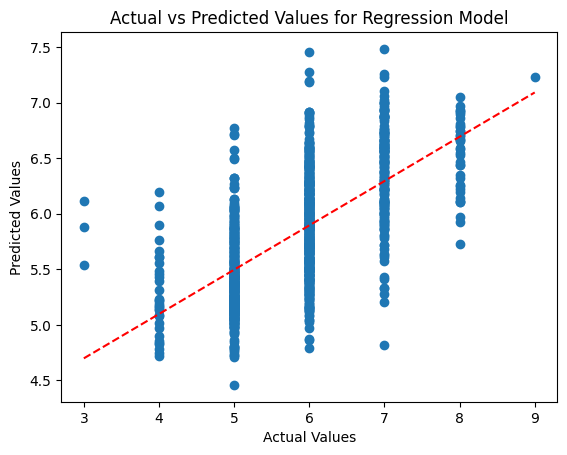

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test.values.ravel(), y_pred, 1))(np.unique(y_test)), color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Regression Model")
plt.show()

### Uploading Model

In [35]:
mr = project.get_model_registry()

model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(model, model_dir + "/wine_model.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"mse" : mse},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/204950/models/wine_model/17


Model(name: 'wine_model', version: 17)